In [1]:
import requests
import pandas as pd
import anndata
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import scanpy as sc

from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def download_file(url, data_name):
    # Get the filename from the URL
    filename = f"data/{data_name}"

    # Send a GET request to the URL
    response = requests.get(url, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the file
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:  # filter out keep-alive new chunks
                    f.write(chunk)
        print(f"File '{filename}' downloaded successfully.")
    else:
        print(f"Error: Unable to download file. HTTP status code: {response.status_code}")

In [3]:
tissue_id = 151507

section = anndata.read_h5ad(f"data/DLPFC/{tissue_id}.h5ad")

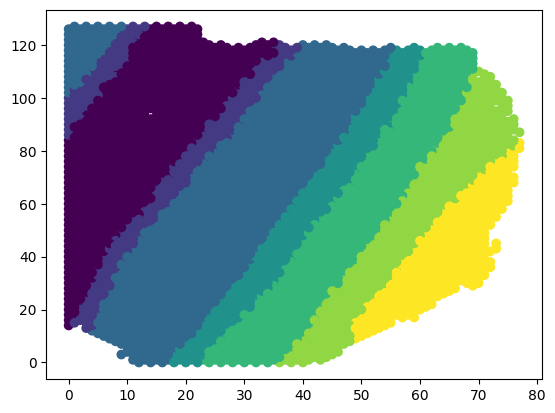

In [4]:
# Assuming section.obs is a pandas DataFrame
section_df = pd.DataFrame(section.obs.reset_index(drop=True))

color_map = {
    'Layer1': 0,
    'Layer2': 1,
    'Layer3': 2,
    'Layer4': 3,
    'Layer5': 4,
    'Layer6': 5,
    'WM': 6
}

# Apply the color map to the 'Region' column
colors = section_df["Region"].map(color_map)

# Plot with colors based on the mapped region colors
plt.scatter(section_df["array_row"], section_df["array_col"], c=colors.to_list())

# Show the plot
plt.show()

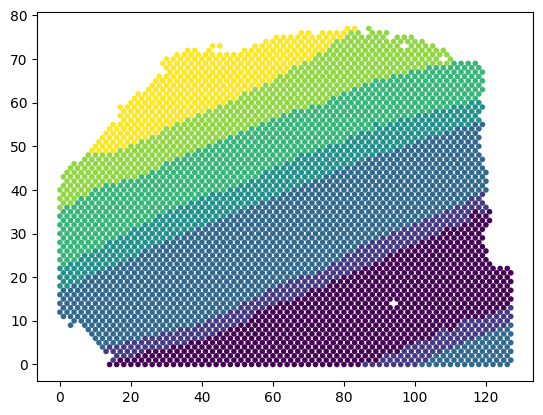

In [5]:
fig, ax = plt.subplots()
ax.scatter(section_df["array_col"], section_df["array_row"], c=colors.tolist(), s=9)

# Invert the y-axis
# ax.invert_yaxis()

In [6]:
section.var["feature_name"] = section.var.index

In [7]:
len(section.var.index.unique())

33538

In [8]:
section.obs["Region"].isna().sum()

5

In [9]:
import numpy as np
np.array(section.X)

array(<4226x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 5959380 stored elements in Compressed Sparse Row format>,
      dtype=object)

In [10]:
clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
clustering.xenium_spot_data = section

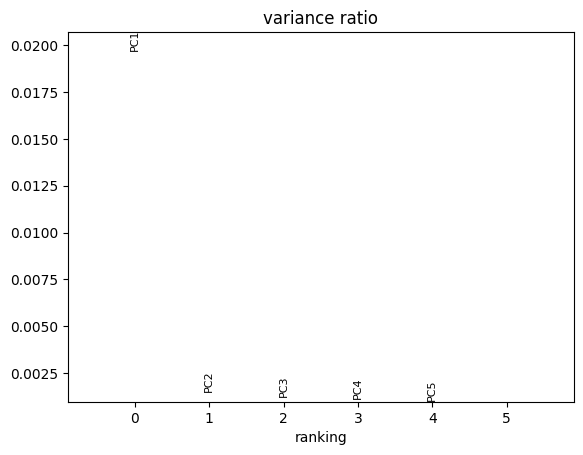

In [11]:
clustering.xenium_spot_data.X = StandardScaler().fit_transform(np.log1p(clustering.xenium_spot_data.X).A)
spatial_locations = section.obs[["array_row", "array_col"]]
spatial_locations.columns = ["row", "col"]
num_pcs = 5
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
sc.pl.pca_variance_ratio(clustering.xenium_spot_data, n_pcs=num_pcs)
gene_data = clustering.xenium_spot_data.obsm["X_pca"]
spatial_init_data = np.concatenate((spatial_locations, gene_data), axis=1)
spatial_init_data = StandardScaler().fit_transform(spatial_init_data)
spatial_init_data[:, :spatial_locations.shape[1]] *= 1.0

In [12]:
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters).fit(spatial_init_data)

initial_clusters = kmeans.predict(spatial_init_data)

/tmp/ipykernel_38867/892545588.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_grid[rows, columns] = torch.tensor(initial_clusters) + 1
/tmp/ipykernel_38867/892545588.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters + 1)


Text(0.5, 1.0, 'Cluster Assignment with KMeans')

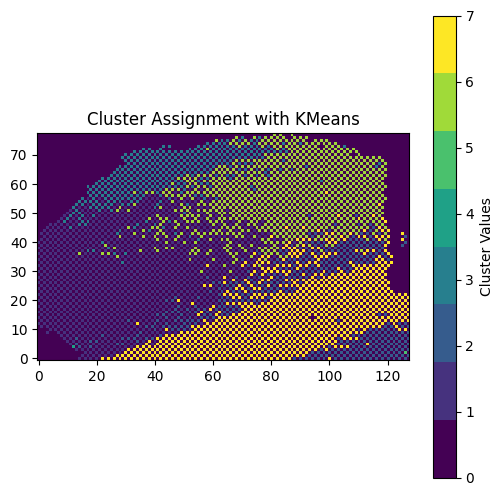

In [13]:
rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = int(max(rows) - min(rows) + 1)
num_cols = int(max(columns) - min(columns) + 1)

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)

cluster_grid[rows, columns] = torch.tensor(initial_clusters) + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
plt.title('Cluster Assignment with KMeans')

In [14]:
# Create a DataFrame for easier handling
data = pd.DataFrame({
    'ClusterAssignments': initial_clusters,
    'Region': section.obs["Region"]
})

# Drop rows where 'Region' is NaN
filtered_data = data.dropna(subset=['Region'])

# Calculate ARI and NMI only for the non-NaN entries
ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
ari, nmi

(0.30347986795922627, 0.4273000206427459)